In [18]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import xarray as xr 
import netCDF4 as s
import cartopy.crs as ccrs
import os
import cmocean as cmo
import cartopy.feature as cfeature
#import regionmask
from pathlib import Path
print(os.getcwd())
plt.rcParams['font.size'] = '13' # making figure text bigger

D:\OneDrive\01_Studium\01_Study\00_Master\SS21\climAPC2\Exercises\Python_Scripts


In [19]:
#inpath='/Users/Ilana/Downloads/Exercises/Data/'
path=(Path(os.getcwd())).parent / 'Data'
infile='sst.mnmean.nc' # sst.mnmean.nc
# ds=xr.open_dataset(inpath+infile) for Ilana
ds = xr.open_dataset(path / infile)
# ds_lsmask = xr.open_dataset(inpath+'lsmask_sst.nc')
infile='lsmask_sst.nc'
ds_lsmask = xr.open_dataset(path / infile)
sst = ds.sst.where(ds_lsmask.mask.values==1) # apply land mask to SST
#sst.shape
sst = sst.rolling(time=3).mean() #apply a rolling mean to smooth the dataset

In [20]:
#sst[2].plot()

In [21]:
## making longitude go from - 180 - 180 instead of 0 - 360
i = sst.lon
sst = xr.concat(
    [sst.sel(lon=i[(i >= 180)]), sst.sel(lon=i[(i < 180)])],
    dim="lon"
)
sst = sst.assign_coords({"lon": (((sst.lon + 180) % 360) - 180)})

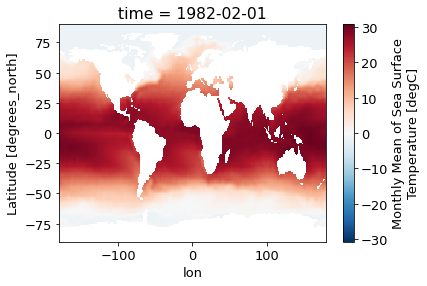

In [22]:
sst[2].plot()

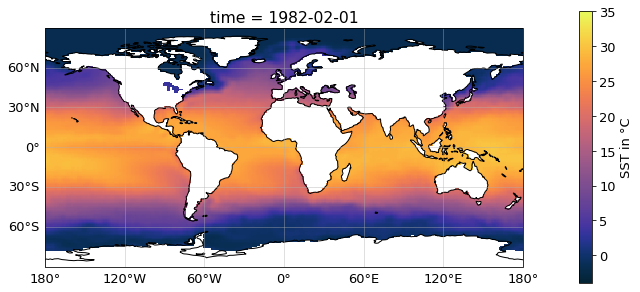

In [23]:
fig = plt.figure(figsize=(10,5))
projection = ccrs.PlateCarree()
ax = plt.axes(projection=projection)
ax.set_extent((-180, 180, -90, 90), crs=projection)
ax.coastlines()

#x = ax.contourf(sst.lon,sst.lat,sst[2], 50, cmap = 'RdBu_r')
#@Ilana, I modified your plot a bit.. I can show you how you can install packages like cmocean
# in your user folder if neded...

x = sst.isel(time=2).plot.pcolormesh(ax=ax, add_colorbar=False, cmap = cmo.cm.thermal, vmin=-4, vmax=35)
cbar = plt.colorbar(x, fraction=.043, pad=0.1)
cbar.set_label('SST in °C')
gridlines = ax.gridlines(draw_labels=True, alpha=.5, ls='--')
gridlines.top_labels = False
gridlines.right_labels = False
plt.show()

In [24]:
#print(sst.lon[129:230])
#print(sst.lat[25:55])
sst_eu = sst[:, 18:60, 155:215]
lon_eu = sst.lon[155:215]
lat_eu = sst.lat[18:60]

In [25]:
#function to make maps so we don't need to keep loading everything all maps (:
def maps_europe(var,title,colorbounds1,colorbounds2,val): #Ilana, what exactly do you do with the last 3 arguments?
    fig = plt.figure(figsize=(9,4))
    projection = ccrs.PlateCarree()
    ax = plt.axes(projection=projection)
    ax.set_extent((-24, 34, 31, 71), crs=projection)
    ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k')
    ax.coastlines(resolution='50m') # you can chose 10, 50 and 110m resolution
    x = ax.contourf(lon_eu,lat_eu,var, np.arange(colorbounds1,colorbounds2,val), cmap = cmo.cm.thermal)
    cbar = plt.colorbar(x, fraction=.043, pad=0.08)
    cbar.set_label("SST ($^\circ C$)", labelpad=-1)
    gridlines = ax.gridlines(draw_labels=True)
    gridlines.top_labels=False
    gridlines.right_labels=False
    # next line not needed anymore, when we disable top labels of the gridlines :)
    #ax.text(.5,1.15, title, va='top',ha='center', rotation='horizontal', rotation_mode= 'anchor',transform=ax.transAxes)
    ax.set_title(title)
    plt.show()

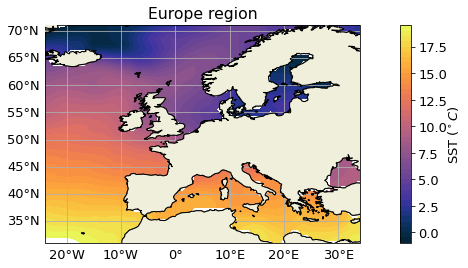

In [26]:
## just making sure we're looking at europe (ssts)
maps_europe(sst_eu[2],'Europe region',-1,20,.5)



In [27]:
# Which location was warmest/coldest/hottest/driest within a three-month period? What
# country or ocean is at that location? At what time did the maximum (minimum) occur?

t_max = sst_eu.max(dim='time') #reduce time dimension and select maximum value over all timsteps at each gridpoint
t_min = sst_eu.min(dim='time')

In [28]:
t_max_lat = t_max.max(dim='lon').idxmax('lat').values.item() #reduce the longitude dimension and select the maximum for
# each gridpoint, then determine latitude value of the maximum along latitude with idxmax() function, extract corres-
# ponding Numpy array by appending .values and convert 1D array to float by appending .item()
t_max_lon = t_max.max(dim='lat').idxmax('lon').values.item() #same but for longitude
t_max_time = sst_eu.sel(lat=t_max_lat, lon=t_max_lon).idxmax('time').values # see http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html#xarray.DataArray.sel
print('The maximum occured at lat ' + str(t_max_lat) + ' and lon ' + str(t_max_lon) + ' at on ' + str(t_max_time)[0:10])

#same for minimum
t_min_lat = t_min.min(dim='lon').idxmin('lat').values.item()
t_min_lon = t_min.min(dim='lat').idxmin('lon').values.item()
t_min_time = sst_eu.sel(lat=t_min_lat, lon=t_min_lon).idxmin('time').values #http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html#xarray.DataArray.sel
print('The minimum occured at lat ' + str(t_min_lat) + ' and lon ' + str(t_min_lon) + ' at on ' + str(t_min_time)[0:10])


The maximum occured at lat 33.5 and lon 10.5 at on 2003-09-01
The minimum occured at lat 71.5 and lon -24.5 at on 1989-02-01


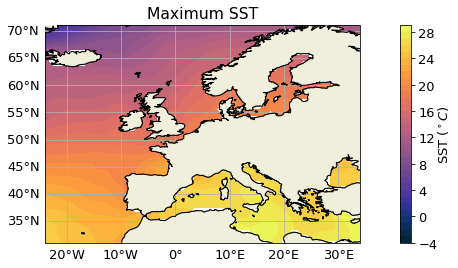

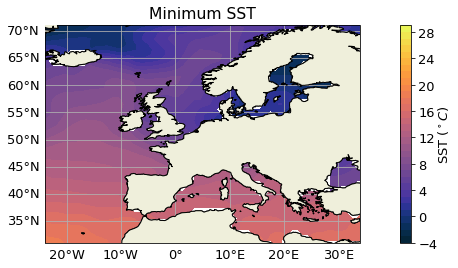

In [35]:
maps_europe(t_max,'Maximum SST',-4, 30,1 )
maps_europe(t_min,'Minimum SST',-4, 30, 1)

# @Ilana can we add the crosses here withs catter for the min and max lon/lat coordinates?

In [22]:
#subtract latitudinal means
lat_means_subtr = sst_eu.mean(dim='time') - sst_eu.mean(dim='time').mean(dim='lon')
maps_europe(lat_means_subtr,'Latitudinal Mean Subtracted',-5,5,.2)


In [27]:
## using only one gridpoint for kiel... not the best resolution so hard to get exactly near kiel 
sst_kiel = sst_eu[:,16,35] #16:18, 33:37
lat_kiel = lat_eu[16]
lon_kiel = lon_eu[35]

#maps_test(sst_kiel[2],'sst kiel')